In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf
import json

# Notes

All values are expressed in todays (nominal) €'s. This makes estimation of prices easier as they can be judged from today.
Thus, also things like the earings/monthly investment growth shall not consider the effects of inflation.

# Setup

In [148]:
# Boundary conditions / external effects
average_inflation_rate_perc = 2.7
#average_inflation_rate_perc = 0
age = 30
capital_tax_rate_perc = 26.3750 

In [149]:
# Income/assets


In [150]:
# Investments
investment_opportunities = {
 "LOW_RISK" : {"yield_per_year_perc" : 1.0, "total_loss_likely" : False}, # Low-risk investments (Bonds/Fonds/…)
 "AVERAGE_RISK" : {"yield_per_year_perc" : 7, "total_loss_likely" : False}, # Average-risk investments (Shares/ETF/…)
 "HIGH_RISK" : {"yield_per_year_perc" : 0, "total_loss_likely" : True},   # High-risk investments (Crypto, …)
 "CASH" : {"yield_per_year_perc" : 0, "total_loss_likely" : False},   
}

investment_structure_var = [(1.0, "AVERAGE_RISK")]
investment_structure_fix = [(0.2, "LOW_RISK"), (0.7, "AVERAGE_RISK")]#, (0.1, "HIGH_RISK")]

In [14]:
# Target
#target_scenario_str = "SCENARIO_INCOME_AGGRESSIVE"
#with open('Targets.json') as f:
#    target_scenario_arr = json.load(f)
#target_scenario = target_scenario_arr[target_scenario_str]
#target_value = target_scenario["target_value"]
#withdrawal_rate = target_scenario["withdrawal_rate_perc"]

import FIRE as fire
import imp
imp.reload(fire)

target = FIRE.FIRETargetArray('Targets.json').select_target("SCENARIO_INCOME_AGGRESSIVE")


# Investment analysis

Investing 100.0% of 1500€ at an average yield of 7.0% per year.
Considering an average inflation rate of 2.7%, the nominal average yield is 4.3% per year.
With a withdrawal rate of 4%, net gain/loss during retirement each year will be 0.2999999999999998


Text(0.5, 1.0, 'Performance of reference investment = 1000€ over time')

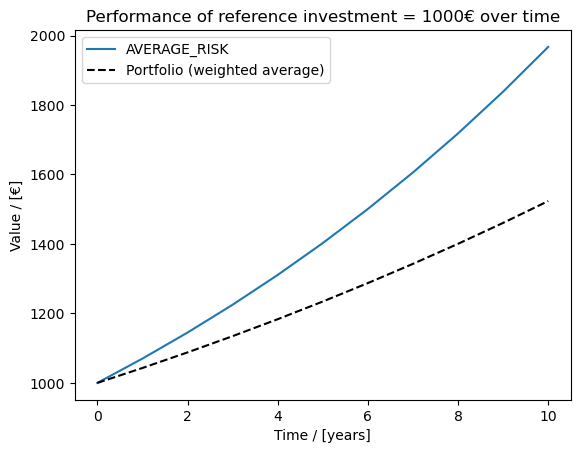

In [156]:
investment_opp_df = pd.DataFrame(investment_opportunities).T
investment_structure_df = pd.DataFrame(investment_structure_var, columns = ["share", "type"]) #investments_montly * 12

investments_df = pd.merge(investment_structure_df,investment_opp_df, left_on="type",right_index=True,how="left")
investments_df["share_total"] = investments_df.share * investments_monthly

total_share = investments_df.share.sum()
avg_yield = (investments_df.share * investments_df.yield_per_year_perc).sum() / total_share

print(f"Investing {total_share*100}% of {investments_monthly}€ at an average yield of {avg_yield}% per year.")
avg_yield -= average_inflation_rate_perc
print(f"Considering an average inflation rate of {average_inflation_rate_perc}%, the nominal average yield is {avg_yield}% per year.")
print(f"With a withdrawal rate of {withdrawal_rate}%, net gain/loss during retirement each year will be {avg_yield-withdrawal_rate}%.")
if avg_yield-withdrawal_rate < 0:
    print("WARING: yearly net loss expected during retirement!")

pers = np.arange(0,11,1)
ref_value = 1000
for ii, row in investments_df.iterrows():
    plt.plot( pers, npf.fv(row.yield_per_year_perc/100., pers, 0, -ref_value), ls="-", label = row.type )
plt.plot( pers, npf.fv(avg_yield/100., pers, 0, -ref_value), ls="--", c="black", label = "Portfolio (weighted average)" )
plt.legend()
plt.xlabel("Time / [years]")
plt.ylabel("Value / [€]")
plt.title(f"Performance of reference investment = {ref_value}€ over time")

# Target analysis

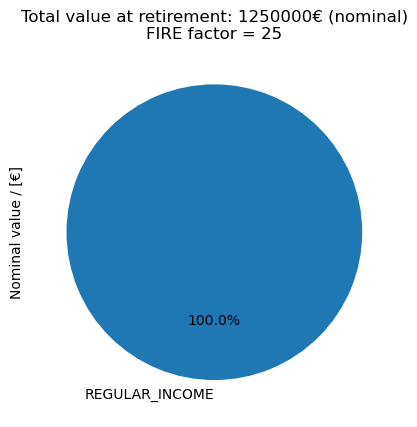

In [15]:
#target_df = pd.DataFrame(target_value).T
#fire_fact = 1./(withdrawal_rate/100.)
#
#valuation_factor_ret_nom = {"YEARLY": fire_fact, "ONE_TIME":1.} # valuation to convert into nominal value at retirement
#target_df["value_ret_nom"] = target_df.value * target_df.frequency.apply(lambda x: valuation_factor_ret_nom[x])
#target_value_total_ret_nom = target_df.value_ret_nom.sum()
#
#plt.figure()
#plt.title(f"Total value at retirement: {int(target_value_total_ret_nom)}€ (nominal)\nFIRE factor = {int(fire_fact)}")
#target_df.value_ret_nom.plot.pie(autopct='%1.1f%%',startangle=90)
#plt.ylabel("Nominal value / [€]")
target.plot_pie_value()

# FIRE analysis

In [154]:
sim_res = {"valuation" : [initial_assets],
           "investment": [investments_monthly],
           "time" : [0],
           "is_ret": [False],
           "ret_time":None,
          "taxes_cum" : [0]}

value_onetime_invest = target_df[target_df.frequency == "ONE_TIME"].value.sum()
value_yearly_invest = target_df[target_df.frequency == "YEARLY"].value.sum()

for p in range(1,71):
    was_ret = sim_res["is_ret"][-1]
    
    v_im1, i_im1 = sim_res["valuation"][-1], sim_res["investment"][-1]
    
    if was_ret:
        i_i = 0.0
        exp_i = value_yearly_invest
    else:
        i_i = investment_growth_perc/100.*i_im1+i_im1
        exp_i = 0
    
    v_i_yrly_n = i_i*12
    v_i_mty = npf.fv(avg_yield/100./12., 12, -i_i, -0, when="begin") ## annualize monthly returns: https://financetrain.com/how-to-annualize-monthly-returns-example
    v_i = npf.fv(avg_yield/100., 1, -v_i_mty+exp_i, -v_im1, when="end")
        
    # taxes
    v_tax = capital_tax_rate_perc/100*(v_i-v_im1-v_i_yrly_n)
    v_i -= v_tax
    
    is_ret = (v_i>=target_value_total_ret_nom)
    
    if is_ret and not was_ret:
        sim_res["ret_time"] = p
        v_i -= value_onetime_invest
    
    sim_res["valuation"].append(v_i)
    sim_res["investment"].append(i_i)
    sim_res["time"].append(p)
    sim_res["is_ret"].append(is_ret or was_ret)
    sim_res["taxes_cum"].append(sim_res["taxes_cum"][-1]+v_tax)
    

Text(0, 0.5, 'Age / [years]')

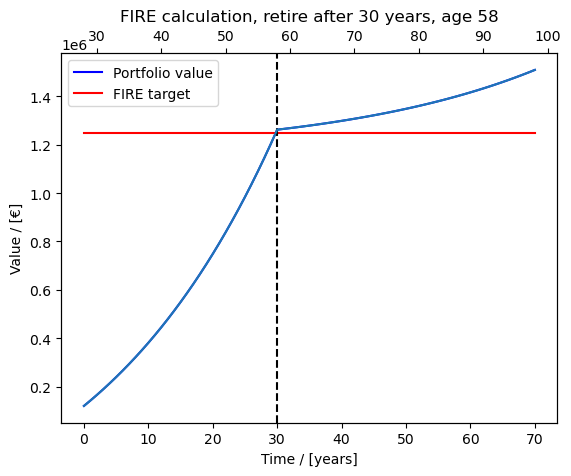

In [155]:
plt.figure()
if sim_res['ret_time'] is None:
    plt.title(f"FIRE calculation, no retirement in selected time span")    
else:
    plt.title(f"FIRE calculation, retire after {sim_res['ret_time']} years, age {sim_res['ret_time']+age}")
plt.plot(sim_res["time"], sim_res["valuation"], label = "Portfolio value", c="blue")
plt.plot(sim_res["time"], [target_value_total_ret_nom for i in sim_res["time"]],label = "FIRE target",c="red")
if sim_res['ret_time'] is not None:
    plt.axvline(sim_res["ret_time"], c="black",ls="--")
plt.legend()
plt.xlabel("Time / [years]")
plt.ylabel("Value / [€]")

ax2=plt.twiny()
ax2.plot(np.array(sim_res["time"])+age,sim_res["valuation"],alpha=1)
ax2.set_ylabel("Age / [years]")

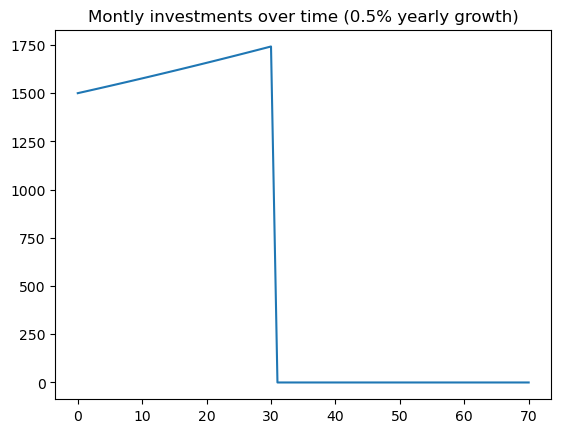

In [141]:
plt.title(f"Montly investments over time ({investment_growth_perc}% yearly growth)")
plt.plot(sim_res['time'], sim_res['investment'])